In [1]:
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import os 

import utils.sde_lib
import utils.models
import utils.losses as losses
from utils.datasets import get_dataset
import utils.samplers
from utils.misc import dotdict, batch_matrix_product

In [2]:
opts =  dotdict({
    'dataset': 'spiral',
    'lr' : 3e-4,
    'num_iters' : 1000,
    'batch_size' : 512, 
    
})
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dataset = get_dataset(opts)
dim = dataset.dim
model_backward = utils.models.MLP(dim=dim,augmented_sde=True).to(device=device)
model_forward = utils.models.MLP(dim=dim,augmented_sde=True).to(device=device)


itr=2000
model_path = f'./exp/momentum/itr_{itr}'

# model_path = f'./checkpoints/cld/itr_{itr}'
model_forward = utils.models.MatrixTimeEmbedding(4,2).to(device=device)
model_backward = torch.load(os.path.join(model_path,f'backward_ema_{itr}.pt'))
# model_forward = torch.load(os.path.join(model_path,f'forward_ema_{itr}.pt'))
sb = utils.sde_lib.LinearMomentumSchrodingerBridge()
# sb = utils.sde_lib.MomentumSchrodingerBridge()
cld = utils.sde_lib.CLD()
sb.backward_score = model_backward
sb.forward_score = model_forward
# sb.forward_score = lambda x,t : 0

In [3]:
from utils.misc import batch_matrix_product

t = torch.linspace(0,1,2, device=device).unsqueeze(0)
x = torch.ones((2,4), device=device)
x[:,-2:]*=3
print(.5 * sb.beta(t) * batch_matrix_product(-sb.D(t),x))
print(sb.drift(x,t,True))

tensor([[ 15.,  15., -35., -35.],
        [ 15.,  15., -35., -35.]], device='cuda:0')
tensor([[ 15.,  15., -35., -35.],
        [ 15.,  15., -35., -35.]], device='cuda:0')


In [4]:
t = torch.linspace(0,1.,100,device=device)
x = dataset.sample(1000).to(device=device)
x = torch.cat((x, torch.rand_like(x)),dim=-1)
z = x
e = torch.randn_like(z)
for i in range(99):
    dt = t[i+1]-t[i]
    t_s =t[i].unsqueeze(-1).expand(1000,1)
    x = x + sb.drift(x,t_s) * dt + torch.randn_like(x) * sb.diffusion(x,t_s) * dt.abs().sqrt()
    z = z + cld.drift(z,t_s) * dt + torch.randn_like(x) * cld.diffusion(x,t_s) * dt.abs().sqrt()
    plt.clf()
    plt.xlim(-4,4)
    plt.ylim(-35,35)
    plt.scatter(x[:,0].cpu(),x[:,1].cpu(),label='sb')
    plt.scatter(z[:,0].cpu(),z[:,1].cpu(), label='cld')
    plt.scatter(e[:,0].cpu(),e[:,1].cpu(), label='normal')
    plt.legend()
    plt.savefig(f'trajectory/{i}.png')
    plt.close()

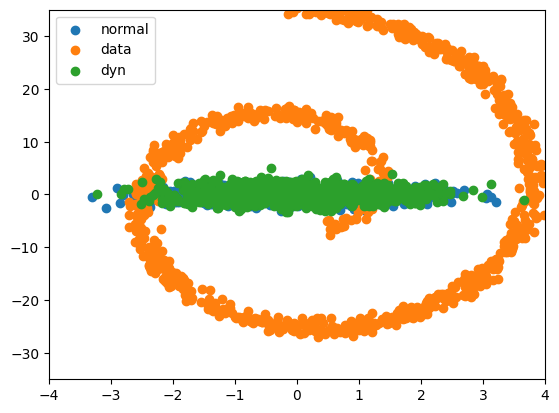

In [5]:
data = dataset.sample(1000).to(device=device)
aug_data = torch.cat((data, torch.zeros_like(data)),dim=-1)

noise, trajectory = cld.sample((1000,4),device,False, in_cond=aug_data)
rand = torch.randn_like(noise)
for i in range(trajectory.shape[1]):
    plt.close()
    plt.xlim(-4,4)
    plt.ylim(-35,35)
    plt.scatter(rand[:,0].cpu(),rand[:,1].cpu(),label='normal')
    plt.scatter(aug_data[:,0].cpu(),aug_data[:,1].cpu(),label='data')
    plt.scatter(trajectory[:,i,0].cpu(),trajectory[:,i,1].cpu(),label='dyn')
    plt.legend()
    plt.savefig(f'trajectory/{i}.png')

In [6]:
sb = utils.sde_lib.LinearMomentumSchrodingerBridge()
model_forward = utils.models.MatrixTimeEmbedding(4,2).to(device=device)
sb.forward_score = model_forward

cld = utils.sde_lib.CLD(beta_max=2.5)

torch.set_printoptions(sci_mode=False, precision=2)

t = torch.linspace(0,1,5,device=device).unsqueeze(-1)
cov, L, invL, max_eig = sb.compute_variance(t)
a,b,c,d = cld.marginal_prob_var_components(t)
print(cov)
covv = torch.zeros_like(cov)
# print(covv[:,0,0].shape ,a.shape)
covv[:,:2,:2] = a.expand(-1,2).diag_embed()
covv[:,:2,-2:] = b.expand(-1,2).diag_embed()
covv[:,-2:,:2] = c.expand(-1,2).diag_embed()
covv[:,-2:,-2:] = d.expand(-1,2).diag_embed()
print(covv)
# print(L)
# print(cld.marginal_prob_std(t))


_LinAlgError: linalg.cholesky: (Batch element 0): The factorization could not be completed because the input is not positive-definite (the leading minor of order 1 is not positive-definite).